# Long Term Trends

## 1. Calculate STAR-PU denominators

In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

# import STAR-PU multipliers and population sizes from BigQuery:
q = '''SELECT * 
FROM ebmdatalab.ONS.oral_antibiotics_star_pu'''
q2 = '''SELECT *
FROM ebmdatalab.ONS.england_population_1998_2016 
'''

m = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)
pop = pd.io.gbq.read_gbq(q2, GBQ_PROJECT_ID, dialect='standard',verbose=False).drop(["location","all_ages"],axis=1)


### 1a. organise table of STAR-PU multipliers

In [2]:
# create age-band groups
m = m.rename(columns={"Age_Band":"age_band"})
m["min_age"] = m["age_band"].str.split('-',expand=True)[0].str.replace("+","").astype(int)
m = m.sort_values(by="min_age") # this sorted table will be used in the next step (1b)

# rearrange data
m2 = pd.DataFrame(m[["age_band","item_male","item_female","cost_male","cost_female"]].set_index("age_band").unstack()).reset_index().sort_values(by="age_band")
m2 = m2.rename(columns={"level_0":"category",0:"multiplier"})

# split gender and items vs cost into separate columns
m2["measure"] = m2["category"].str.split('_',expand=True)[0]
m2["gender"] = m2["category"].str.split('_',expand=True)[1]

# rearrange table
m2 = m2.drop("category",axis=1)
m2 = m2.set_index(["age_band","gender","measure"]).unstack().reset_index(col_level=1)
m2.columns = m2.columns.droplevel()
m2.head()

measure,age_band,gender,cost,item
0,0-4,female,2.8,0.8
1,0-4,male,3.2,0.8
2,15-24,female,2.5,0.6
3,15-24,male,2.1,0.3
4,25-34,female,2.0,0.6


### 1b. Apply multipliers to population each year (1998-2016)

In [3]:
# rearrange population data:
p2 = pd.DataFrame(pop.set_index(["year","gender"]).stack()).reset_index()
p2["gender"] = p2.gender.str.lower()
p2 = p2.rename(columns={"level_2":"_age",0:"population"})
p2["age"] = p2["_age"].str.replace("_","").astype(int)

# Group into age bands
conditions = [
    (p2['age']<5 ),
    (p2['age']<15 ),
    (p2['age']<25 ),
    (p2['age']<35 ),
    (p2['age']<45 ),
    (p2['age']<55 ),
    (p2['age']<65 ),
    (p2['age']<75 ),
    (p2['age']>=75)]
choices = m["age_band"].drop_duplicates().values # assign each age to an age band from the table formed above
p2['age_band'] = np.select(conditions, choices)

p3 = pd.DataFrame(p2.groupby(["year","age_band","gender"])["population"].sum()).reset_index()
# join to STAR-PU multipliers:
p3 = p3.merge(m2,on=["age_band","gender"])
p3["item_star-pu"] = p3.population*p3.item
p3["cost_star-pu"] = p3.population*p3.cost
starpu = pd.DataFrame(p3.groupby(["year"])["item_star-pu","cost_star-pu"].sum()).reset_index()
starpu.head()

,year,item_star-pu,cost_star-pu
0,1998,26914610.0,111491490.0
1,1999,27018730.0,111926740.0
2,2000,27127640.0,112364760.0
3,2001,27249436.5,112905819.5
4,2002,27392281.2,113551221.2


## 2. Import prescribing data

### 2a. Prescribing by paragraph

In [4]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q4 = '''SELECT 
  year,
  para_current,
  sum(CASE WHEN (chemical_code_current LIKE '0501080W0%' OR chemical_current LIKE 'Trimethoprim%') THEN ItemsPer1000 ELSE 0 END) AS trimeth_per_1000,
  sum(CASE WHEN (chemical_current LIKE 'Ampi%' or chemical_current LIKE 'Amox%') THEN ItemsPer1000 ELSE 0 END) AS amp_amox_per_1000,
  SUM(IF(chemical_code_current='0501013K0' OR
         SUBSTR(chemical_code_current,1,7)='0501021' OR
         para_code_current='12',items,0)) AS all_broad_spectrum,
  SUM(IF(SUBSTR(chemical_code_current,1,9)='0501013K0' OR
         SUBSTR(chemical_code_current,1,7)='0501021' OR
         para_code_current IN ('12','13','03','05','08','11','01'),items,0)) AS denom_broad_spectrum,
  sum(items) as items, 
  sum(ItemsPer1000) as items_per_1000, 
  sum(quantity) AS quantity,
  sum(Infl_corr_Cost) as cost
FROM ebmdatalab.helen.trends_from_pca_final_2016 p
WHERE chapter_code_current = '05' AND section_code_current = '01'
GROUP BY 
  year,
  para_current'''

dfl = pd.io.gbq.read_gbq(q4, GBQ_PROJECT_ID, dialect='standard',verbose=False).fillna(0)
dfl.head()

,year,para_current,trimeth_per_1000,amp_amox_per_1000,all_broad_spectrum,denom_broad_spectrum,items,items_per_1000,quantity,cost
0,2012,Macrolides,0.0,0.0,0.0,5205786.0,5205786.0,97.315871,235306714.0,3.678457e+07
1,2016,Macrolides,0.0,0.0,0.0,4421982.0,4421982.0,80.009662,183693680.0,2.128058e+07
2,2002,Macrolides,0.0,0.0,0.0,4407141.0,4407141.0,88.711818,237094942.0,4.225814e+07
3,2015,Macrolides,0.0,0.0,0.0,4552746.0,4552746.0,83.100082,194291521.0,2.586846e+07
4,1998,Macrolides,0.0,0.0,0.0,5680000.0,5680000.0,116.344330,339588400.0,4.264914e+07


### 2b. Extract prescribing data for penicillins broken down by chemical

In [5]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

q5 = '''SELECT 
  year,
  chemical_current,
  sum(items) as items, 
  sum(ItemsPer1000) as items_per_1000, 
  sum(quantity) AS quantity,
  sum(Infl_corr_Cost) as cost
FROM ebmdatalab.helen.trends_from_pca_final_2016 p
WHERE chapter_code_current = '05' AND section_code_current = '01' AND para_code_current = "01"
GROUP BY 
  year,
  chemical_current'''

dfc = pd.io.gbq.read_gbq(q5, GBQ_PROJECT_ID, dialect='standard',verbose=True).fillna(0)
dfc.head()

Requesting query... ok.
Job ID: 0d69a28a-df55-4ade-9b85-f71155f6bc02
Query running...
Query done.
Processed: 11.7 MB Billed: 12.0 MB
Standard price: $0.00 USD

Retrieving results...
Got 217 rows.

Total time taken 3.72 s.
Finished at 2018-04-06 16:28:05.


,year,chemical_current,items,items_per_1000,quantity,cost
0,2005,Ampicillin,33647.0,0.664882,1359229.0,167198.772876
1,2003,Ampicillin,58947.0,1.180699,2358199.0,184225.888363
2,2012,Ampicillin,5564.0,0.104012,271191.0,91512.303814
3,2000,Ampicillin,137876.0,2.800462,5480894.0,449481.431076
4,2002,Ampicillin,77820.0,1.566447,3105535.0,234198.976664


## 3. Data processing

### 3a. Data by paragraph

In [6]:
# Merge data with STAR-PU multipliers
l2 = dfl.merge(starpu, on="year")
# calculate prescribing rates per 1,000 STAR-PU
l2["items_per_starpu"] = 1000*l2["items"]/l2["item_star-pu"]
l2["cost_per_starpu"] = 1000*l2["cost"]/l2["cost_star-pu"]
l2["itemsm"] = l2["items"]/1000000 # total items in millions
l2["costm"] = l2["cost"]/1000000

# sort by overall prescribing level and re-group lesser-prescribed items to "other"
total = pd.DataFrame(l2.groupby("para_current")["items_per_starpu"].sum().sort_values(ascending=False))
sort_order = total.copy().head(8)
sort_order.loc["Other"] = 0
l4 = l2.merge(pd.DataFrame(sort_order).reset_index(), how="left",on="para_current",suffixes=("","_overall"))
l4["group"] = np.where(pd.notnull(l4["items_per_starpu_overall"]),l4["para_current"],"Other")
l4["other_group"] = np.where(pd.isnull(l4["items_per_starpu_overall"]),l4["para_current"],"Other")

# rearrange data for plotting (individual drugs as columns, measures as rows)
l3 = l4.drop(["item_star-pu","cost_star-pu","quantity"],axis=1)
l3 = l3.groupby(["year","group"]).sum().reset_index() 
l3 = pd.DataFrame(l3.set_index(["year","group"]).stack()).reset_index(col_level=1)
l3 = l3.rename(columns={"level_2":"measure",0:"value"})
l3 = pd.DataFrame(l3.set_index(["year","measure","group"]).unstack()).reset_index(col_level=1)
l3.columns = l3.columns.droplevel()
l3["total"] = l3.drop("year",axis=1).sum(axis=1)

# separately calculate the proportion of all types prescribed as broad-spectrum
lx = l2.groupby("year")["denom_broad_spectrum","all_broad_spectrum"].sum().reset_index()
lx["percent_broad_spectrum"] = 100*lx["all_broad_spectrum"]/lx["denom_broad_spectrum"]

l3.head()

group,year,measure,Cephalosporins and other Beta-Lactams,Macrolides,"Metronidazole, Tinidazole & Ornidazole",Other,Penicillins,Quinolones,Sulfonamides And Trimethoprim,Tetracyclines,Urinary-Tract Infections,total
0,1998,all_broad_spectrum,3.950400e+06,0.000000e+00,0.000000e+00,0.000000e+00,2.369900e+06,1.309300e+06,0.000000e+00,0.000000e+00,0.000000e+00,7.629600e+06
1,1998,amp_amox_per_1000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.178535e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.178535e+02
2,1998,cost,2.979772e+07,4.264914e+07,2.237888e+06,9.455900e+06,8.002058e+07,2.921078e+07,3.383916e+06,3.147271e+07,1.907926e+06,2.301366e+08
3,1998,cost_per_starpu,2.672646e+02,3.825327e+02,2.007227e+01,8.481275e+01,7.177281e+02,2.620001e+02,3.035134e+01,2.822880e+02,1.711275e+01,2.064163e+03
4,1998,costm,2.979772e+01,4.264914e+01,2.237888e+00,9.455900e+00,8.002058e+01,2.921078e+01,3.383916e+00,3.147271e+01,1.907926e+00,2.301366e+02


### 3b. Penicillin data subset

In [7]:
# Merge data with STAR-PU multipliers

pen = dfc.merge(starpu, on="year")
# calculate prescribing rates per 1,000 STAR-PU
pen["items_per_starpu"] = 1000*pen["items"]/pen["item_star-pu"]
pen["itemsm"] = pen["items"]/1000000 # total items in millions

# set sort order
ptotal = pd.DataFrame(pen.groupby("chemical_current")["items_per_1000"].sum().sort_values(ascending=False))
pen_order = ptotal.head(6)
pen_order.loc["Other"] = 0
pen_order.loc["year"] = 0

pen3 = pen.merge(pd.DataFrame(pen_order).reset_index(), how="left",on="chemical_current",suffixes=("","_overall"))
pen3["group"] = np.where(pd.notnull(pen3["items_per_1000_overall"]),pen3["chemical_current"],"Other")
pen3 = pen3.drop(["item_star-pu","cost_star-pu","quantity"],axis=1)
pen3 = pen3.groupby(["year","group"]).sum().reset_index()

# rearrange data for plotting (individual drugs as columns, measures as rows)
pen = pd.DataFrame(pen3.set_index(["year","group"]).stack()).reset_index(col_level=1)
pen = pen.rename(columns={"level_2":"measure",0:"value"})
pen2 = pd.DataFrame(pen.set_index(["year","measure","group"]).unstack()).reset_index(col_level=1).fillna(0)
pen2.columns = pen2.columns.droplevel()


pen2

C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


group,year,measure,Amoxicillin,Co-Amoxiclav (Amoxicillin/Clavul Acid),Co-Fluampicil(Flucloxacillin/Ampicillin),Flucloxacillin Magnesium,Flucloxacillin Sodium,Other,Phenoxymethylpenicillin (Penicillin V)
0,1998,cost,2.831424e+07,3.205471e+07,3.585175e+06,2.601935e+06,9.328752e+06,6.920296e+05,3.443742e+06
1,1998,items,1.520130e+07,2.369900e+06,3.254000e+05,2.281000e+05,2.242400e+06,3.586000e+05,3.179400e+06
2,1998,items_per_1000,3.113706e+02,4.854303e+01,6.665219e+00,4.672208e+00,4.593143e+01,7.345260e+00,6.512415e+01
3,1998,items_per_1000_overall,4.861477e+03,7.039675e+02,6.629042e+01,7.384987e+01,1.233000e+03,0.000000e+00,9.437743e+02
4,1998,items_per_starpu,5.647973e+02,8.805255e+01,1.209009e+01,8.474951e+00,8.331534e+01,1.332362e+01,1.181291e+02
5,1998,itemsm,1.520130e+01,2.369900e+00,3.254000e-01,2.281000e-01,2.242400e+00,3.586000e-01,3.179400e+00
6,1999,cost,3.867313e+07,2.704570e+07,3.499639e+06,2.924490e+06,1.591507e+07,6.152337e+05,8.938417e+06
7,1999,items,1.364940e+07,1.997800e+06,2.986000e+05,2.756000e+05,2.395800e+06,2.202000e+05,2.818000e+06
8,1999,items_per_1000,2.783723e+02,4.074407e+01,6.089789e+00,5.620716e+00,4.886107e+01,4.490862e+00,5.747162e+01
9,1999,items_per_1000_overall,4.861477e+03,7.039675e+02,6.629042e+01,7.384987e+01,1.233000e+03,0.000000e+00,9.437743e+02


## 4. Trends Charts

### 4a. Main figures

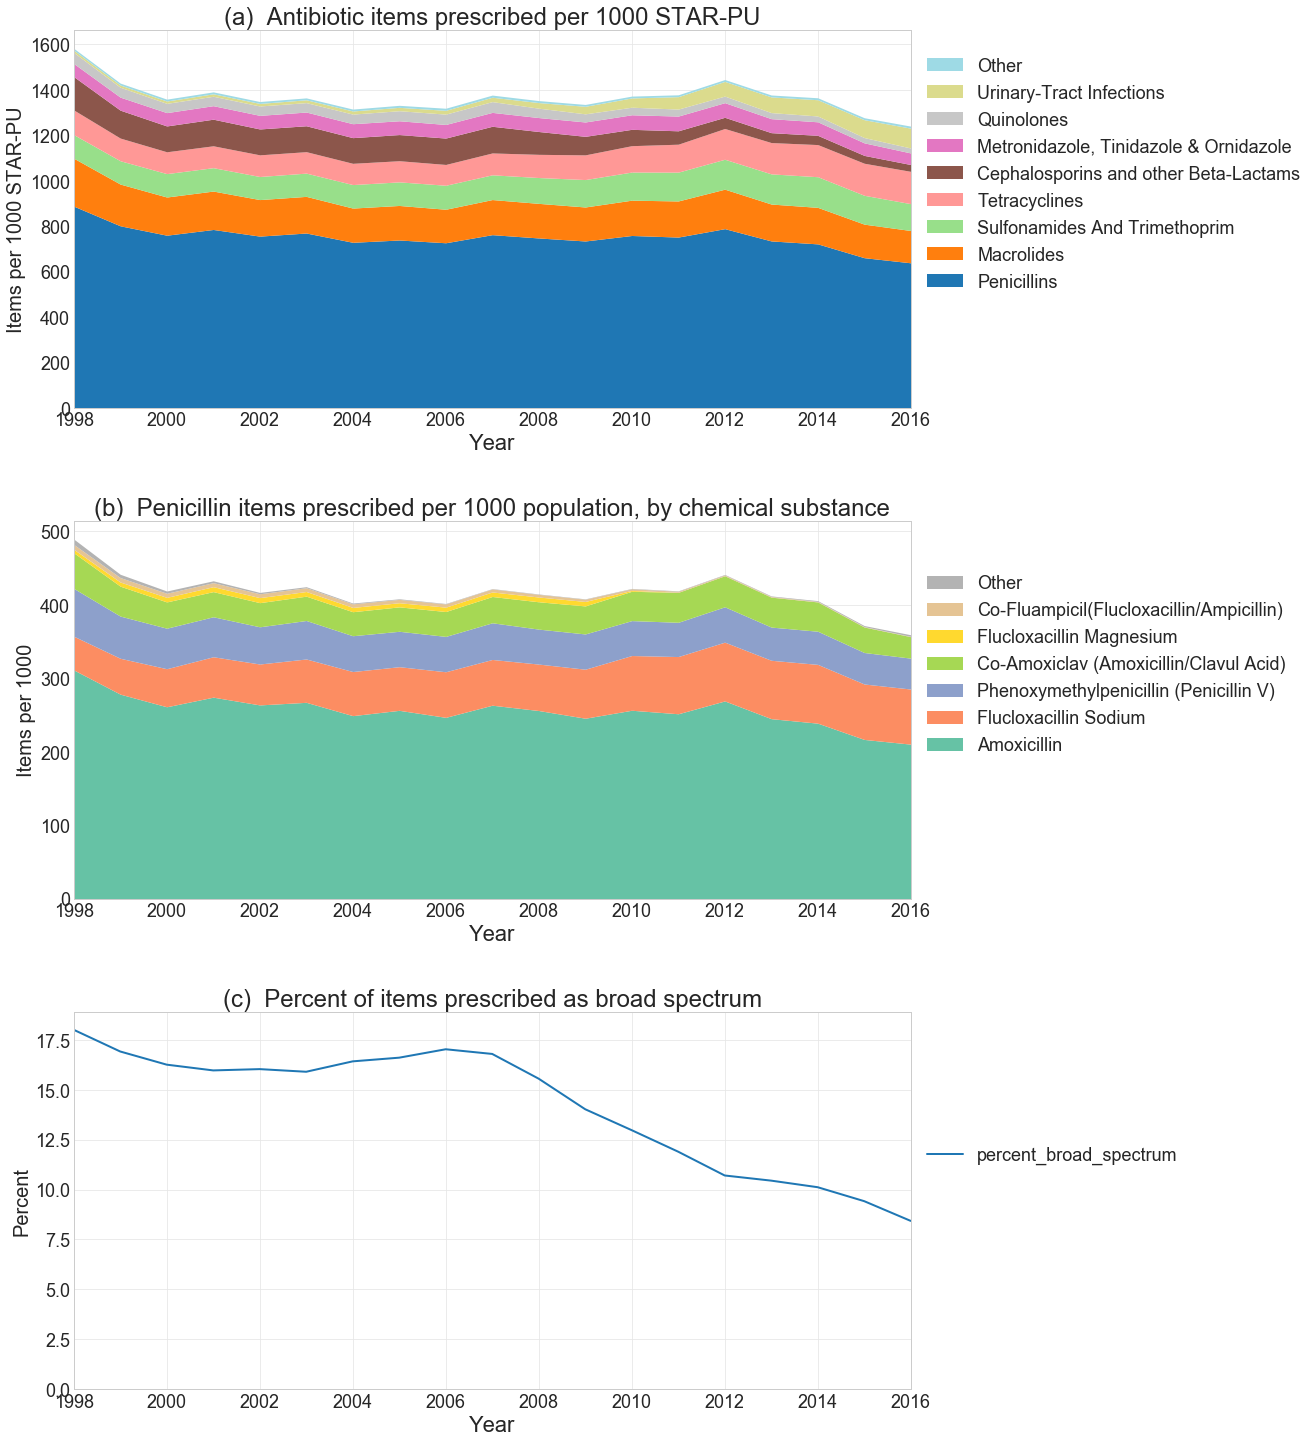

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sns.set_style("whitegrid",{'grid.color': '.9'})

sort_order.loc["year"] = 0    

# set order, measure, axis label, title, chart type, line width & colour scheme:
s = [(0,"items_per_starpu","Items per 1000 STAR-PU", "(a)  Antibiotic items prescribed per 1000 STAR-PU","area",0,"tab20"),
     (1,"items_per_1000","Items per 1000", "(b)  Penicillin items prescribed per 1000 population, by chemical substance","area",0,"Set2"),
     (2,"percent_broad_spectrum","Percent","(c)  Percent of items prescribed as broad spectrum","line",2,"tab20")
]

fig = plt.figure(figsize=(15,25))
   
for i in s:
    ax = plt.subplot(3,1,i[0]+1)  # layout and position of subplot
    if i[0] == 1:
        dfp = pen2
        dfp = dfp.loc[dfp["measure"] == i[1]].drop("measure",axis=1)
        dfp = dfp.reindex(columns=pen_order.index)
        ymax = 1.05*dfp.drop("year",axis=1).sum(axis=1).max() 
    elif i[0] == 2: 
        dfp = lx[["year","percent_broad_spectrum"]]
        ymax = 1.05*dfp.drop("year",axis=1).max().max()
    else:    
        dfp = l3.loc[l3["measure"] == i[1]].drop(["measure","total"],axis=1)
        dfp = dfp.reindex(columns=sort_order.index)
        ymax = 1.05*l3[["total","measure"]].loc[l3["measure"]==i[1]]["total"].max()
    dfp.plot(ax=ax, x="year", kind=i[4], linewidth=i[5],cmap=i[6])
    ax.set_xlabel('Year', fontsize="22")
    ax.set_ylabel(i[2], size="20")
    ax.set_title(i[3], size="24")
    ax.tick_params(labelsize=18)
    ax.set_ylim([0,ymax])
    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(reversed(handles), reversed(labels),loc='center left', bbox_to_anchor=(1, .62), fontsize='18')

plt.subplots_adjust(hspace = 0.3)

plt.show()


### 4b. Supplementary trends figures

**i) Summary results table**

In [9]:
results = l3.pivot(index="year",columns="measure",values="total").reset_index()[["year","items_per_starpu","itemsm","cost_per_starpu","costm"]]
results = results.rename(columns={"items_per_starpu": "Items per 1,000 STAR-PU","cost_per_starpu": "Cost per 1,000 STAR-PU","costm":"Total Cost (2016 equivalent £ millions)","itemsm":"Total Items (millions)"})
results = results.merge(lx[["year","percent_broad_spectrum"]],on="year")
results.rename(columns={"percent_broad_spectrum":"Percent broad-spectrum"})

,year,"Items per 1,000 STAR-PU",Total Items (millions),"Cost per 1,000 STAR-PU",Total Cost (2016 equivalent £ millions),Percent broad-spectrum
0,1998,1583.363088,42.615600,2064.162524,230.136555,17.997141
1,1999,1430.015400,38.637200,2206.903492,247.011513,16.910063
2,2000,1359.348181,36.875908,2119.231216,238.126907,16.251155
3,2001,1391.369286,37.914029,1969.436361,222.360826,15.962922
4,2002,1348.879260,36.948880,1952.662788,221.727244,16.027637
5,2003,1364.839944,37.597529,1967.575007,224.777207,15.895622
6,2004,1315.610513,36.463038,1953.835825,224.630246,16.416285
7,2005,1332.080613,37.240737,1798.409032,208.532204,16.600842
8,2006,1319.310170,37.175639,1839.914112,215.011640,17.021804
9,2007,1377.184379,39.175949,1808.106047,213.282166,16.787676


**ii) Additional trends charts**

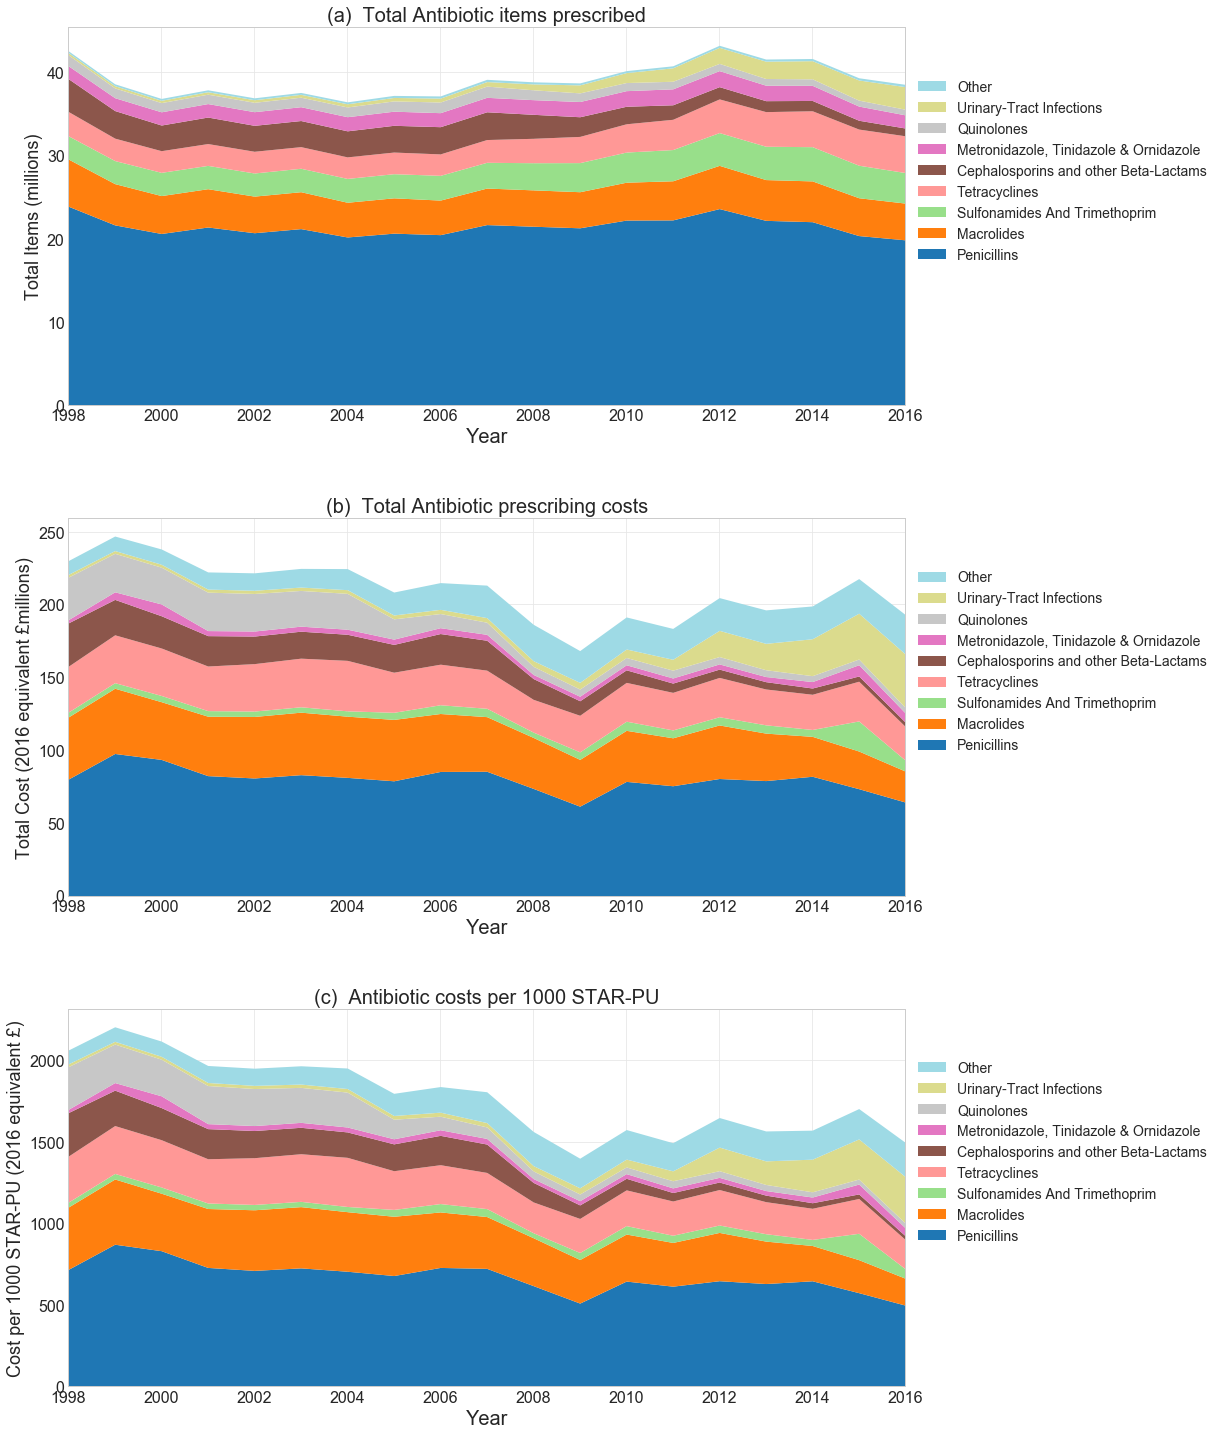

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid",{'grid.color': '.9'})

sort_order.loc["year"] = 0

s = [(0,"itemsm","Total Items (millions)", "(a)  Total Antibiotic items prescribed"),
     (1,"costm","Total Cost (2016 equivalent £millions)", "(b)  Total Antibiotic prescribing costs"),
     (2,"cost_per_starpu","Cost per 1000 STAR-PU (2016 equivalent £)", "(c)  Antibiotic costs per 1000 STAR-PU")
    ]

fig = plt.figure(figsize=(15,25))
   
for i in s:
    ax = plt.subplot(3,1,i[0]+1)  # layout and position of subplot        
    dfp = l3.drop("total",axis=1)
    dfp = dfp.loc[dfp["measure"] == i[1]].drop("measure",axis=1)
    dfp = dfp.reindex(columns=sort_order.index)
    dfp.plot(ax=ax, x="year", kind='area',  linewidth=0, cmap="tab20")
    #dfp.plot(ax=ax, kind='area',  linewidth=0)
    ax.set_xlabel('Year', fontsize="20")
    ax.set_ylabel(i[2], size="18")
    ax.set_title(i[3], size="20")
    ax.tick_params(labelsize=16)
    handles, labels = ax.get_legend_handles_labels()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(reversed(handles), reversed(labels),loc='center left', bbox_to_anchor=(1, .62), fontsize='14')
    
plt.subplots_adjust(hspace = 0.3)

plt.show()

